#### Imports & Setup

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import ee
import geemap
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime, timedelta
from scipy import stats

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# authenticate & init GEE
ee.Authenticate()
ee.Initialize(project='')

#### Target Data from Weather Stations
Source: [Open Energy Data Initiative (OEDI)](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=sup3ruhi%2F)

In [ ]:
madis_la_2016 = pd.read_csv("/content/drive/madis_los_angeles_2016_clean_filtered.csv", delimiter=",")

In [ ]:
madis_la_2016['time_index_dt'] = pd.to_datetime(madis_la_2016['time_index'])
madis_la_2016.head()

,time_index,latitude,longitude,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt
0,2016-01-01 00:00:00,34.09472,-118.65667,2016-01-01 00:00:00,12.66668,21.0,2.906611,30.0,34.09472_-118.65667,2016-01-01 00:00:00
1,2016-01-01 01:00:00,34.09472,-118.65667,2016-01-01 00:30:00,11.94445,22.0,1.476455,48.0,34.09472_-118.65667,2016-01-01 01:00:00
2,2016-01-01 02:00:00,34.09472,-118.65667,2016-01-01 01:30:00,10.77776,23.0,1.965178,24.0,34.09472_-118.65667,2016-01-01 02:00:00
3,2016-01-01 03:00:00,34.09472,-118.65667,2016-01-01 02:30:00,9.94445,24.0,2.371589,104.0,34.09472_-118.65667,2016-01-01 03:00:00
4,2016-01-01 04:00:00,34.09472,-118.65667,2016-01-01 03:30:00,9.66668,25.0,1.250100,101.0,34.09472_-118.65667,2016-01-01 04:00:00


In [ ]:
mean_lon, mean_lat = madis_la_2016.longitude.mean(), madis_la_2016.latitude.mean()
min_lon, min_lat = madis_la_2016[['longitude', 'latitude']].values.min(axis=0)
max_lon, max_lat = madis_la_2016[['longitude', 'latitude']].values.max(axis=0)
bounding_box = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
print('min lon,lat:', min_lon, min_lat)
print('max lon, lat:', max_lon, max_lat)

min lon,lat: -119.37125 33.309795
max lon, lat: -117.40817 35.11383


#### Remotely sensed data with GEE

In [ ]:
start_date = '2016-01-01'
end_date = '2016-12-31'

In [ ]:
# get all tiles within 2016 where at least 70% overlap
landsat = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(bounding_box).filterDate(start_date, end_date))
bounding_box_area = bounding_box.area()

def compute_overlap(image):
    overlap = image.geometry().intersection(bounding_box).area().divide(bounding_box_area)
    return image.set('overlap_fraction', overlap)

landsat_filt = landsat.map(compute_overlap).filter(ee.Filter.gte('overlap_fraction', 0.7))
print(landsat_filt.size().getInfo())

22


#### Sample satellite iamges at points of weather stations

In [ ]:
# get dates at which those tiles are taken
avail_dates = landsat_filt.aggregate_array('system:time_start').map(
      lambda d: ee.Date(d).format('YYYY-MM-dd HH:mm:ss')
  ).distinct().getInfo()
print(avail_dates)

['2016-01-14 18:28:25', '2016-01-30 18:28:23', '2016-02-15 18:28:15', '2016-03-02 18:28:13', '2016-03-18 18:28:08', '2016-04-03 18:27:58', '2016-04-19 18:27:53', '2016-05-05 18:27:56', '2016-05-21 18:27:56', '2016-06-06 18:28:00', '2016-06-22 18:28:05', '2016-07-08 18:28:14', '2016-07-24 18:28:19', '2016-08-09 18:28:21', '2016-08-25 18:28:28', '2016-09-10 18:28:33', '2016-09-26 18:28:33', '2016-10-12 18:28:39', '2016-10-28 18:28:41', '2016-11-13 18:28:40', '2016-11-29 18:28:40', '2016-12-15 18:28:36']


In [ ]:
# filter target data based on selected dates, +- an hour
filter_arr = []
for datet in avail_dates:
  filter_arr.append(madis_la_2016[
    (madis_la_2016['time_index_dt'] >= pd.to_datetime(datet) - pd.Timedelta(minutes=60)) &
    (madis_la_2016['time_index_dt'] <= pd.to_datetime(datet) + pd.Timedelta(minutes=60))
  ])

filter_2016 = pd.concat(filter_arr)
# sort such that 2016-06-22 18:30:00 is at the top
filter_2016 = filter_2016.iloc[(filter_2016['time_index_dt'] - pd.to_datetime('2016-06-22 18:30:00')).abs().argsort()]
# filter to only have unique stations
filter_2016['date'] = filter_2016['time_index_dt'].dt.date
filter_2016 = filter_2016.drop_duplicates(subset=['sid', 'date'])
filter_2016.head()

,time_index,latitude,longitude,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt,date
1905018,2016-06-22 18:00:00,34.281708,-119.212710,2016-06-22 17:35:25,18.88888,78.0,1.34112,227.0,34.281708_-119.21271,2016-06-22 18:00:00,2016-06-22
1358482,2016-06-22 19:00:00,33.770424,-118.150696,2016-06-22 18:38:53,22.77776,74.0,1.78816,196.0,33.770424_-118.150696,2016-06-22 19:00:00,2016-06-22
1338664,2016-06-22 19:00:00,34.171330,-118.042500,2016-06-22 18:43:54,30.55557,43.0,0.00000,40.0,34.17133_-118.0425,2016-06-22 19:00:00,2016-06-22
1329962,2016-06-22 19:00:00,34.042170,-118.521170,2016-06-22 18:42:31,21.11110,81.0,0.89408,253.0,34.04217_-118.52117,2016-06-22 19:00:00,2016-06-22
1321247,2016-06-22 19:00:00,35.058390,-119.084160,2016-06-22 18:30:10,33.33334,21.0,0.00000,0.0,35.05839_-119.08416,2016-06-22 19:00:00,2016-06-22


In [ ]:
filter_2016.groupby(['time_index_dt']).sid.count()

,sid
time_index_dt,
2016-01-14 19:00:00,323
2016-01-30 18:00:00,4
2016-01-30 19:00:00,318
2016-02-15 18:00:00,13
2016-02-15 19:00:00,311
2016-03-02 18:00:00,2
2016-03-02 19:00:00,316
2016-03-18 18:00:00,4
2016-03-18 19:00:00,321


In [ ]:
# weather stations into feature coll
features = []
for _, row in filter_2016.iterrows():
    point = ee.Geometry.Point([row['longitude'], row['latitude']])
    feature = ee.Feature(point, {"temperature": row["temperature"], "sid": row["sid"], "date": str(row["date"])})
    features.append(feature)

fc_0622 = ee.FeatureCollection(features)

In [ ]:
def extract_bands(landsat):
    # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
    qa_mask = landsat.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
    saturation_mask = landsat.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    def _get_factor_img(factor_names):
        factor_list = landsat.toDictionary().select(factor_names).values()
        return ee.Image.constant(factor_list)

    scale_img = _get_factor_img([
        'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
    offset_img = _get_factor_img([
        'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
    scaled = landsat.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

    landsat = landsat.addBands(scaled, None, True).updateMask(
        qa_mask).updateMask(saturation_mask)

    red = landsat.select('SR_B4').rename('Red')
    green = landsat.select('SR_B3').rename('Green')
    blue = landsat.select('SR_B2').rename('Blue')
    swir1 = landsat.select('SR_B6').rename('SWIR1')
    swir2 = landsat.select('SR_B7').rename('SWIR2')
    lst = landsat.select('ST_B10').rename('LST').subtract(273.15)

    # compute indices
    ndvi = landsat.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndbi = landsat.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    nbai = landsat.normalizedDifference(['SR_B7', 'SR_B5']).rename('NBAI')
    mndwi = landsat.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

    band_dict = {
        'NIR': landsat.select('SR_B5'),
        'RED': landsat.select('SR_B4'),
        'BLUE': landsat.select('SR_B2')
    }

    evi = landsat.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', band_dict).rename('EVI')
    savi = landsat.expression('((NIR - RED) / (NIR + RED + 0.5)) * 1.5', band_dict).rename('SAVI')

    return lst.addBands([red, green, blue, swir1, swir2, ndvi, evi, savi, mndwi, nbai, ndbi])


In [ ]:
# iteratrue thorugh landsat iamges/dates, sample at target locations
total_arr = []
for i in range(landsat_filt.size().getInfo()):
    image = ee.Image(landsat_filt.toList(1, i).get(0))
    datet = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

    features = []
    for _, row in filter_2016[filter_2016.date == datetime.strptime(datet, '%Y-%m-%d').date()].iterrows():
        point = ee.Geometry.Point([row['longitude'], row['latitude']])
        feature = ee.Feature(point, {"temperature": row["temperature"], "sid": row["sid"], "date": str(row["date"])})
        features.append(feature)

    fc_date = ee.FeatureCollection(features)

    # extract bands at this date
    bands_date = extract_bands(image)

    # extra non-temporally dependent
    srtm = ee.Image("USGS/SRTMGL1_003").select("elevation").rename("Elevation")
    elevation = srtm.clip(bounding_box)
    slope = ee.Terrain.slope(srtm).rename("Slope")
    slope = slope.clip(bounding_box)
    # distance to water using ESA WorldCover (water mask = 80)
    water = ee.Image("ESA/WorldCover/v200/2021").select("Map").eq(80).selfMask()
    water_dist = water.fastDistanceTransform().rename("Water_dist")

    bands_date = bands_date.addBands([elevation, slope, water_dist])

    # sample from bands via created feature collection
    extracted = bands_date.sampleRegions(collection=fc_date, scale=30, geometries=True)

    # create input feature df
    input_feat = []
    for feature in extracted.getInfo()['features']:
        properties = feature['properties']
        coordinates = feature['geometry']['coordinates']

        input_feat.append({
            'sid': properties.get('sid'),
            'date': properties.get('date'),
            'longitude': coordinates[0],
            'latitude': coordinates[1],
            'RED': properties.get('Red'),
            'GREEN': properties.get('Green'),
            'BLUE': properties.get('Blue'),
            'SWIR1': properties.get('SWIR1'),
            'SWIR2': properties.get('SWIR2'),
            'NDVI': properties.get('NDVI'),
            'NDBI': properties.get('NDBI'),
            'NBAI': properties.get('NBAI'),
            'MNDWI': properties.get('MNDWI'),
            'EVI': properties.get('EVI'),
            'SAVI': properties.get('SAVI'),
            'LST': properties.get('LST'),
            'Elevation': properties.get('Elevation'),
            'Slope': properties.get('Slope'),
            'Water_dist': properties.get('Water_dist')
        })

    extracted_df = pd.DataFrame(input_feat)
    total_arr.append(extracted_df)

In [ ]:
extracted_total = pd.concat(total_arr)
extracted_total = extracted_total.dropna().drop_duplicates()
extracted_total.head()

,sid,date,longitude,latitude,RED,GREEN,BLUE,SWIR1,SWIR2,NDVI,NDBI,NBAI,MNDWI,EVI,SAVI,LST,Elevation,Slope,Water_dist
0,34.08567_-117.68217,2016-01-14,-117.682125,34.085716,0.239698,0.219815,0.176585,0.302343,0.282735,0.127830,-0.012441,-0.045934,-0.158051,0.123375,0.100408,12.516112,351,1.453782,820
1,33.95033_-117.49283,2016-01-14,-117.492738,33.950258,0.104370,0.089052,0.056878,0.177795,0.136738,0.355288,-0.104753,-0.232114,-0.332559,0.202659,0.209462,18.501065,262,0.000000,2117
2,33.85552_-117.60785,2016-01-14,-117.607971,33.855585,0.051598,0.049122,0.024125,0.085670,0.062487,0.461966,-0.241430,-0.383418,-0.271139,0.174577,0.192118,13.879902,333,4.627367,2581
3,33.73283_-118.30533,2016-01-14,-118.305280,33.732755,0.093178,0.093288,0.073047,0.124528,0.088942,0.376098,-0.245385,-0.395889,-0.143424,0.230820,0.210978,20.685179,75,5.782417,5153
4,33.77635_-117.89374,2016-01-14,-117.893828,33.776463,0.094745,0.081462,0.067190,0.122217,0.104067,0.195081,-0.070192,-0.149558,-0.200093,0.095263,0.093672,22.048969,39,2.163695,1681


#### Merge with target data

In [ ]:
extracted_total['date'] = pd.to_datetime(extracted_total['date']).dt.date
comb_2016 = pd.merge(filter_2016, extracted_total, on=['sid', 'date'], how='left')
comb_2016 = comb_2016.dropna()
print(comb_2016.shape)
comb_2016.head()

(4064, 28)


,time_index,latitude_x,longitude_x,time_obs,temperature,relative_humidity,wind_speed,wind_dir,sid,time_index_dt,...,NDVI,NDBI,NBAI,MNDWI,EVI,SAVI,LST,Elevation,Slope,Water_dist
0,2016-06-22 18:00:00,34.281708,-119.212710,2016-06-22 17:35:25,18.88888,78.0,1.34112,227.0,34.281708_-119.21271,2016-06-22 18:00:00,...,0.385507,-0.096927,-0.234386,-0.364507,0.269859,0.265836,39.043365,100.0,3.704792,1706.0
1,2016-06-22 19:00:00,33.770424,-118.150696,2016-06-22 18:38:53,22.77776,74.0,1.78816,196.0,33.770424_-118.150696,2016-06-22 19:00:00,...,0.227021,-0.007564,-0.114215,-0.272882,0.155409,0.139348,44.830073,24.0,0.927410,1777.0
2,2016-06-22 19:00:00,34.171330,-118.042500,2016-06-22 18:43:54,30.55557,43.0,0.00000,40.0,34.17133_-118.0425,2016-06-22 19:00:00,...,0.473158,-0.210547,-0.391375,-0.257185,0.254705,0.250237,39.778239,323.0,3.834991,10421.0
3,2016-06-22 19:00:00,34.042170,-118.521170,2016-06-22 18:42:31,21.11110,81.0,0.89408,253.0,34.04217_-118.52117,2016-06-22 19:00:00,...,0.326712,-0.072214,-0.210666,-0.275438,0.227137,0.197853,40.099533,97.0,1.119171,2045.0
4,2016-06-22 19:00:00,35.058390,-119.084160,2016-06-22 18:30:10,33.33334,21.0,0.00000,0.0,35.05839_-119.08416,2016-06-22 19:00:00,...,0.145337,0.119321,0.067947,-0.371339,0.098337,0.109322,52.267684,147.0,4.762867,106.0


In [ ]:
# encode day of year
comb_2016['dayofyear'] = comb_2016['time_index_dt'].map(lambda x: pd.to_datetime(x).dayofyear)
comb_2016['sin_time'] = np.sin(2*np.pi*comb_2016.dayofyear/365)
comb_2016['cos_time'] = np.cos(2*np.pi*comb_2016.dayofyear/365)

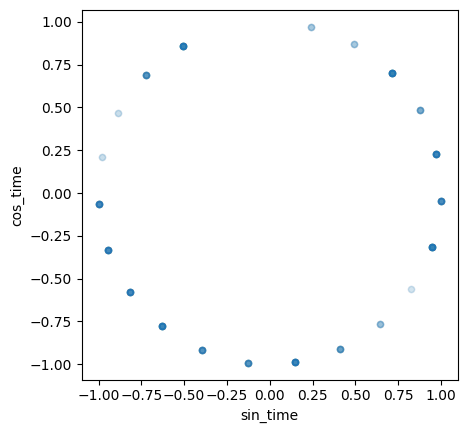

In [ ]:
comb_2016.sample(500).plot.scatter('sin_time','cos_time', alpha=0.05).set_aspect('equal')

#### Outliers

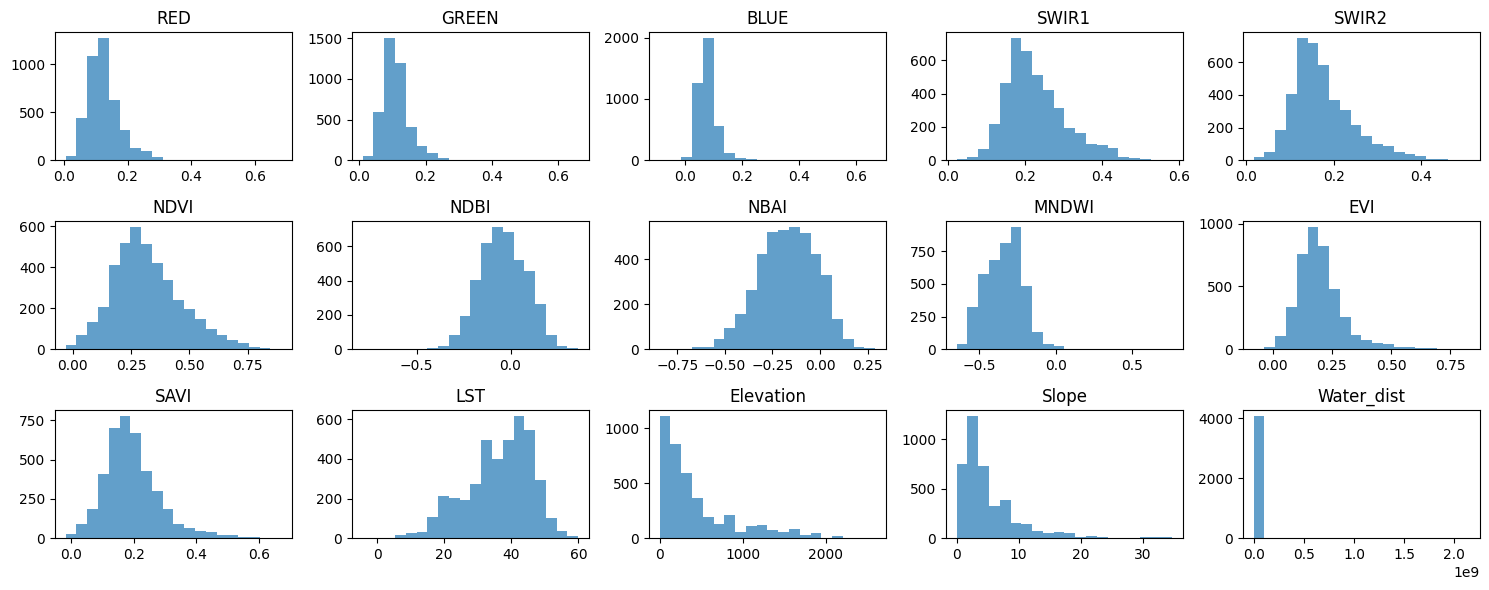

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
axes = axes.flatten()

for i, col in enumerate(['RED', 'GREEN', 'BLUE', 'SWIR1',
       'SWIR2', 'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST', 'Elevation', 'Slope', 'Water_dist']):
    axes[i].hist(comb_2016[col], bins=20, alpha=0.7)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
z_scores = stats.zscore(comb_2016[['RED', 'GREEN', 'BLUE', 'SWIR1',
       'SWIR2', 'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST', 'Water_dist']])
print('total # outliers:', (abs(z_scores) > 3).sum(axis=0).sum())
(abs(z_scores) > 3).sum(axis=0).sort_values(ascending=False)

total # outliers: 379


,0
EVI,71
SAVI,59
BLUE,45
SWIR2,45
GREEN,40
RED,29
SWIR1,29
NDVI,14
MNDWI,13
NBAI,12


In [ ]:
comb_2016 = comb_2016[(abs(z_scores) <= 3).all(axis=1)]
print(comb_2016.shape)

(3882, 31)


In [ ]:
for col in ['Elevation', 'Slope']:
  comb_2016[col] = (comb_2016[col] - comb_2016[col].min()) / (comb_2016[col].max() - comb_2016[col].min())


#### Scaling

In [ ]:
comb_2016.to_csv('/content/drive/2016_LA_merged_scaled.csv', index=False)

,temperature
temperature,1.000000
LST,0.768374
SWIR1,0.120950
SWIR2,0.111228
Elevation,-0.124415


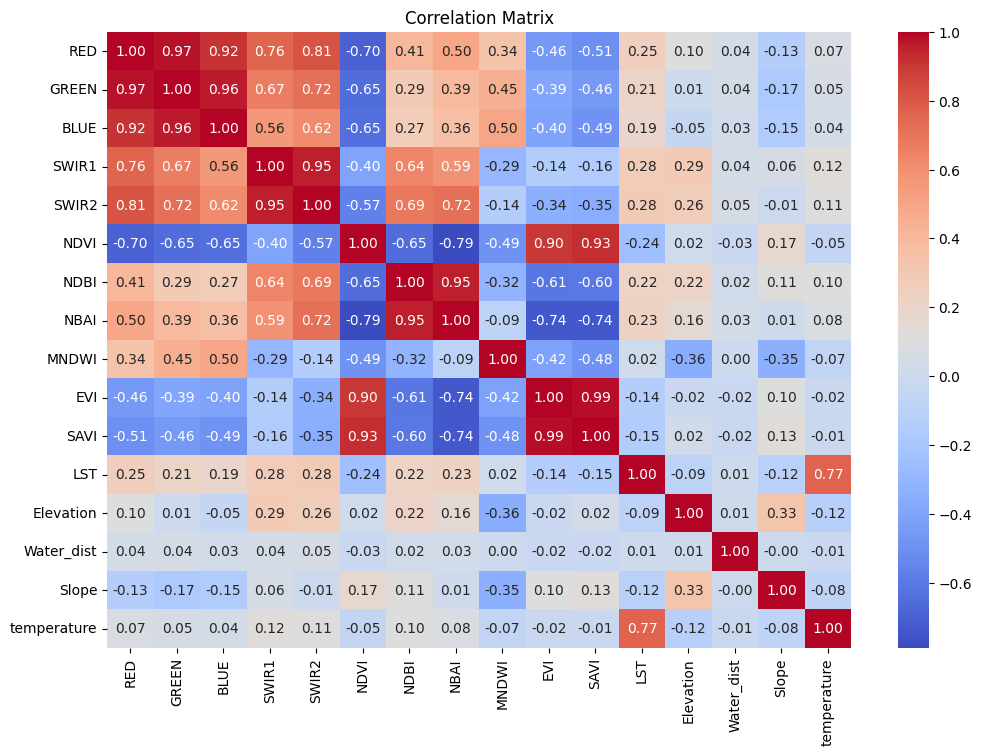

In [ ]:
df_numeric = comb_2016[['RED', 'GREEN', 'BLUE', 'SWIR1', 'SWIR2',
       'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'SAVI', 'LST', 'Elevation',
       'Water_dist', 'Slope', 'temperature']]
corr_matrix = df_numeric.select_dtypes(include='number').corr()

# variables where correlation is bigger than 0.1
display(pd.DataFrame(corr_matrix[abs(corr_matrix) > 0.1]['temperature'].dropna().sort_values(ascending=False)))

# create heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()